# PCM development notebook

The aim of this notebook is to create a PCM model and train it with a dataset. Some figures that could help to PCM model development are also plotted.
__TODO__: explain more (pyxpcm, where to find some exemples of models or datasets) and logos 

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## User input
***

__Choose dataset__

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1600874641188_caribe.nc'
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'

Variables names in dataset (__TODO__: find an elegant way to do that)

In [3]:
# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
lat_dim = 'latitude'
z_dim = 'depth'
var_name = 'thetao_oras' #temp_var = 'fe'

__Model options__

In [4]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z} #pcm_features = {'iron': z}
# {variable name in model: variable name in dataset}
features_in_ds = {'temperature': var_name}

# number of classes
K=6

__Plot options__

## Load training dataset
***

In [5]:
ds = xr.open_dataset(file_path)

#some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'

ds

<xarray.Dataset>
Dimensions:      (depth: 75, latitude: 69, longitude: 197, time: 12)
Coordinates:
  * latitude     (latitude) float32 30.0 30.25 30.5 30.75 ... 46.5 46.75 47.0
  * longitude    (longitude) float32 -6.0 -5.75 -5.5 -5.25 ... 42.5 42.75 43.0
  * depth        (depth) float32 -0.50576 -1.555855 ... -5698.061 -5902.058
  * time         (time) datetime64[ns] 2017-01-16 ... 2017-12-13T12:00:00
Data variables:
    zos_glor     (time, latitude, longitude) float32 ...
    uo_glor      (time, depth, latitude, longitude) float32 ...
    so_glor      (time, depth, latitude, longitude) float32 ...
    uo_oras      (time, depth, latitude, longitude) float32 ...
    vo_foam      (time, depth, latitude, longitude) float32 ...
    so_cglo      (time, depth, latitude, longitude) float32 ...
    mlotst_foam  (time, latitude, longitude) float32 ...
    thetao_oras  (time, depth, latitude, longitude) float32 ...
    mlotst_cglo  (time, latitude, longitude) float32 ...
    zos_oras     (time, latitude, longitude) float32 ...
    thetao_cglo  (time, depth, latitude, longitude) float32 ...
    so_oras      (time, depth, latitude, longitude) float32 ...
    vo_cglo      (time, depth, latitude, longitude) float32 ...
    uo_cglo      (time, depth, latitude, longitude) float32 ...
    zos_cglo     (time, latitude, longitude) float32 ...
    vo_oras      (time, depth, latitude, longitude) float32 ...
    thetao_glor  (time, depth, latitude, longitude) float32 ...
    mlotst_oras  (time, latitude, longitude) float32 ...
    thetao_foam  (time, depth, latitude, longitude) float32 ...
    uo_foam      (time, depth, latitude, longitude) float32 ...
    mlotst_glor  (time, latitude, longitude) float32 ...
    so_foam      (time, depth, latitude, longitude) float32 ...
    vo_glor      (time, depth, latitude, longitude) float32 ...
    zos_foam     (time, latitude, longitude) float32 ...
Attributes:
    product:                       GLOBAL_REANALYSIS_PHY_001_031
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    area:                          Global
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    credit:                        E.U. Copernicus Marine Service Information...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    references:                    http://marine.copernicus.eu
    licence:                       http://marine.copernicus.eu/services-portf...
    institution:                   Mercator Ocean
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    history:                       Creation 2020-MAY-20 08:00:00 GMT+0200
    title:                         Monthly mean fields for product GLOBAL_REA...
    dataset:                       global-reanalysis-phy-001-031-grepv2-monthly
    source:                        Copernicus Marine Service
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:

Quick plot of dataset

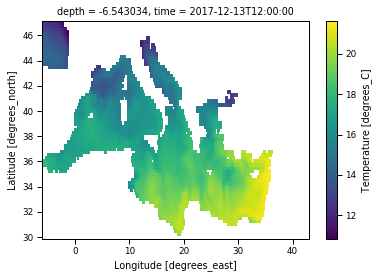

In [6]:
ds[var_name].isel(time=11, depth=5).plot();

## Create and train model
***

### Create PCM

In [7]:
#z choise
z = ds['depth'][0:20]
pcm_features = {'temperature': z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [8]:
m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 44.704830

## Development plots
***

__Scatter plot of features, as seen by the classifier__

__TODO__: Plot only first dimension for each feature

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim=z_dim)

In [ ]:
g = m.plot.preprocessed(ds, features=features_in_ds, kde=True, dim=z_dim)

__Mask__

In [ ]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=z_dim)
mask.plot()

__BIC__

In [21]:
#### using all dataset

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(dsp, features=features_in_ds, dim=z_dim)
        #calculate BIC
        BIC[k,run] = m.bic(dsp, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
1
2
3
4
5
6
7
8
9
13.186210787296295


In [23]:
#### using random lat and lon

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)
#choose random sample of dataset
n_lat = np.int(dsp.latitude.size/2)
n_lon = np.int(dsp.longitude.size/2)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #random sample
        i_lat = np.random.choice(range(dsp.latitude.size), n_lat, replace=False)
        i_lon = np.random.choice(range(dsp.longitude.size), n_lon, replace=False)
        ds_ran = dsp.isel(latitude=i_lat, longitude=i_lon)
        
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(ds_ran, features=features_in_ds, dim=z_dim)
        
        #calculate BIC
        BIC[k,run] = m.bic(ds_ran, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
1
2
3
4
5
6
7
8
9
1.9104728778203328


In [16]:
#### using only profiles not touching

import time
start = time.time()

#only one snapshot for the moment
dsp = ds.isel(time=0)

# Since we have more observations than the maximum independant sample size, 
# we can run several BIC computations
kmax = 20
#Nrun = 1
Nrun = 10
BIC = np.zeros((kmax,Nrun))
BICf = np.zeros((kmax,Nrun))

for run in range(Nrun):
    print(run)
    for k in range(kmax):
        #print(k)
        #random sample
        latp = np.random.choice(range(dsp.latitude.size), 1, replace=False)
        lonp = np.random.choice(range(dsp.latitude.size), 1, replace=False)
        i_lat = np.concatenate((np.arange(0,latp,2),np.arange(latp,dsp.latitude.size,2)))
        i_lon = np.concatenate((np.arange(0,lonp,2),np.arange(lonp,dsp.longitude.size,2)))
        #print(i_lat)
        #print(i_lon)
        ds_ran = dsp.isel(latitude=i_lat, longitude=i_lon)
        
        #create model
        m = pcm(K=k+1, features=pcm_features)
        #fit model
        m.fit(ds_ran, features=features_in_ds, dim=z_dim)
        #calculate BIC
        BIC[k,run] = m.bic(ds_ran, features=features_in_ds, dim=z_dim)
        
end = time.time()
print((end - start)/60)

0
1
2
3
4
5
6
7
8
9
2.2573187867800395


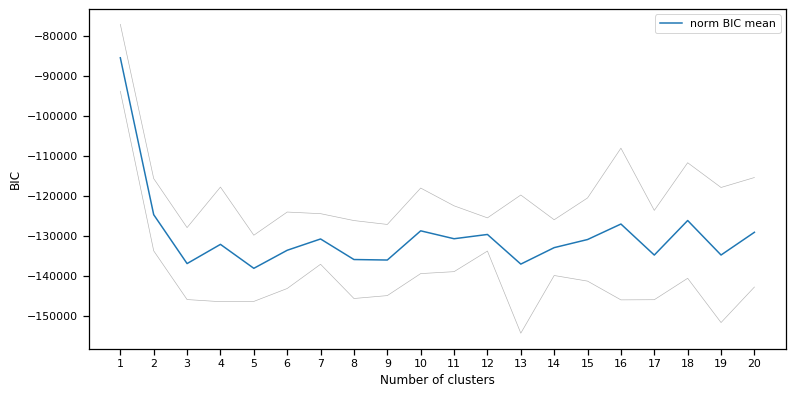

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
normBICstd = np.std(normBICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(kmax)+1,BICmean,label='norm BIC mean')
plt.plot(np.arange(kmax)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(kmax)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(kmax)+1)
plt.legend()

__Robustness__

Description

In [ ]:
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

In [ ]:
P = Plotter(ds, m)
P.plot_robustness(time_slice=7)

## Save fitted model
***

In [ ]:
# save model to development
#m.to_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')